In [1]:
import os
import glob
import gzip
import math
import random
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LineGraph

import network_io as nio
import processing_io as pio

# Parameters to define
is_for_1pm = False
result_path = "dataset_1pct_0_100"

if is_for_1pm:
    base_dir = '../../../../data/pop_1pm_with_policies/'
    subdirs_pattern = os.path.join(base_dir, 'output_networks_*')
    subdirs = list(set(glob.glob(subdirs_pattern)))
    subdirs.sort()
    base_output_links_no_policies = '../../../data/pop_1pm/output_1pm/'
else:
    base_path = '../../../../data/pop_1pct_with_policies/output_networks_100/'
    network_folders = glob.glob(os.path.join(base_path, 'network_d_*'))
    base_output_links_no_policies = '../../../../data/pop_1pct/output_1pct/'

districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

## Process results

Process the outputs of the simulations for further usage by GNN. Further, one can analyze and plot the results.

In [2]:
# Read all network data into a dictionary of GeoDataFrames
result_dic = {}

if is_for_1pm:
    # Loop through each subdirectory
    for subdir in subdirs:
        print(f'Accessing folder: {subdir}')
        print(len(os.listdir(subdir)))
        for network in os.listdir(subdir):
            folder = os.path.join(subdir, network)
            file_path = os.path.join(subdir, network)
            if file_path.endswith(".DS_Store"):
                continue
            policy_key = pio.create_policy_key_1pm(network)
            gdf = nio.read_network_data(file_path)
            if gdf is not None:
                result_dic[policy_key] = gdf
else:
    for folder in network_folders:
        policy_key = pio.create_policy_key_1pct(os.path.basename(folder))
        try:
            gdf = nio.read_network_data(folder)
        except Exception:
            print(f"Error reading folder: {folder}")
        
        if gdf is not None:
            result_dic[policy_key] = gdf
        break
        
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
result_dic["base_network_no_policies"] = base_network_no_policies

In [3]:
# data_processed = pio.process_result_dic(result_dic)
# torch.save(data_processed, result_path + '.pt')

## Analyze and plot

policy introduced in Arrondissement(s) 2, 4, 5, 6, 9, 11, 13, 15, 16
     link   from_node     to_node     length  freespeed  capacity  lanes  \
0  100315    24972409    24972408  16.181257   8.333333     480.0    1.0   
1  100316  5904976363    24983651  14.860209   8.333333     240.0    1.0   
2  100317    24983651  5904976363  14.860209   8.333333     480.0    2.0   
3  100321   664205947    24972376  22.264540   8.333333     960.0    2.0   
4  100324    24972376    24972375  64.853276   8.333333     480.0    1.0   

                      modes  vol_car  storageCapacityUsedInQsim  \
0     bus,car,car_passenger       54                        NaN   
1  bus,car,car_passenger,pt       40                        NaN   
2  bus,car,car_passenger,pt       18                        NaN   
3         car,car_passenger       67                        NaN   
4     bus,car,car_passenger       75                        NaN   

                                            geometry  
0  LINESTRING (6

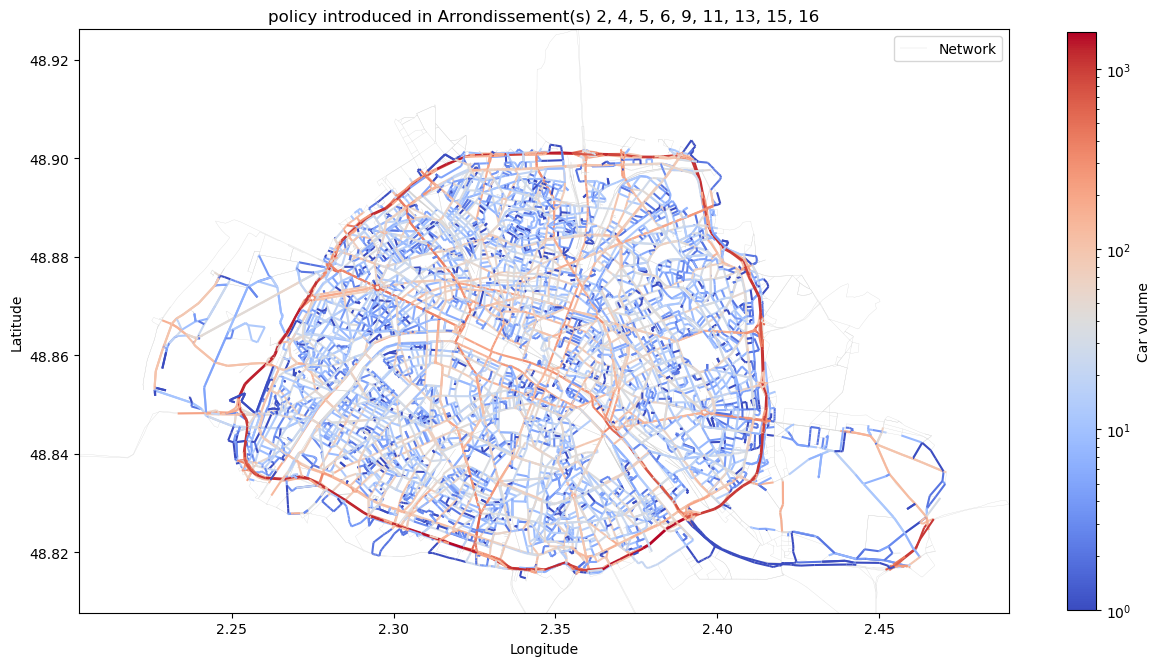

In [4]:
for key, df in result_dic.items():
    print(key)
    pio.plot_policy_data(key, df)
    break

pio.analyze_geodataframes(result_dic)